In [1]:
import pandas as pd
df = pd.read_csv('azerbaijan_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:58:10.830000,VER,1,0 days 00:01:55.490000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:44.610000,...,True,Red Bull Racing,0 days 00:56:15.070000,2024-09-15 11:04:10.845,1,5.0,False,NaN,False,False
1,0 days 01:00:00.462000,VER,1,0 days 00:01:49.632000,2.0,1.0,NaN,NaN,0 days 00:00:39.449000,0 days 00:00:44.481000,...,True,Red Bull Racing,0 days 00:58:10.830000,2024-09-15 11:06:06.605,1,5.0,False,NaN,False,True
2,0 days 01:01:49.592000,VER,1,0 days 00:01:49.130000,3.0,1.0,NaN,NaN,0 days 00:00:39.118000,0 days 00:00:44.415000,...,True,Red Bull Racing,0 days 01:00:00.462000,2024-09-15 11:07:56.237,1,5.0,False,NaN,False,True
3,0 days 01:03:39.200000,VER,1,0 days 00:01:49.608000,4.0,1.0,NaN,NaN,0 days 00:00:39.046000,0 days 00:00:44.387000,...,True,Red Bull Racing,0 days 01:01:49.592000,2024-09-15 11:09:45.367,1,5.0,False,NaN,False,True
4,0 days 01:05:28.445000,VER,1,0 days 00:01:49.245000,5.0,1.0,NaN,NaN,0 days 00:00:39.312000,0 days 00:00:44.211000,...,True,Red Bull Racing,0 days 01:03:39.200000,2024-09-15 11:11:34.975,1,5.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,0 days 02:21:17.720000,PIA,81,0 days 00:01:47.060000,47.0,2.0,NaN,NaN,0 days 00:00:38.234000,0 days 00:00:43.372000,...,True,McLaren,0 days 02:19:30.660000,2024-09-15 12:27:26.435,1,1.0,False,NaN,False,True
969,0 days 02:23:05.208000,PIA,81,0 days 00:01:47.488000,48.0,2.0,NaN,NaN,0 days 00:00:38.379000,0 days 00:00:43.709000,...,True,McLaren,0 days 02:21:17.720000,2024-09-15 12:29:13.495,1,1.0,False,NaN,False,True
970,0 days 02:24:52.755000,PIA,81,0 days 00:01:47.547000,49.0,2.0,NaN,NaN,0 days 00:00:38.498000,0 days 00:00:43.621000,...,True,McLaren,0 days 02:23:05.208000,2024-09-15 12:31:00.983,1,1.0,False,NaN,False,True
971,0 days 02:26:40.013000,PIA,81,0 days 00:01:47.258000,50.0,2.0,NaN,NaN,0 days 00:00:38.358000,0 days 00:00:43.501000,...,True,McLaren,0 days 02:24:52.755000,2024-09-15 12:32:48.530,12,1.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 51  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              1              32.0               25.5   
1    ALO              1              12.0               25.5   
2    BEA              1              15.0               25.5   
3    BOT              1              12.0               25.0   
4    COL              1              11.0               25.5   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0               0.0          0.392157         0.607843  
1               0.0          0.215686         0.784314  
2               0.0          0.274510         0.725490  
3               0.0          0.220000         0.780000  
4               0.0          0.196078         0.803922  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,31.0,0 days 01:52:59.609000,NaN,HARD,31.0,1.0
1,ALB,32.0,NaN,0 days 01:53:19.942000,MEDIUM,1.0,2.0
2,ALO,11.0,0 days 01:16:32.554000,NaN,MEDIUM,12.0,1.0
3,ALO,12.0,NaN,0 days 01:16:52.671000,HARD,2.0,2.0
4,BEA,14.0,0 days 01:22:14.514000,NaN,MEDIUM,14.0,1.0
5,BEA,15.0,NaN,0 days 01:22:35.613000,HARD,1.0,2.0
6,BOT,11.0,0 days 01:17:06.153000,NaN,MEDIUM,12.0,1.0
7,BOT,12.0,NaN,0 days 01:17:26.235000,HARD,2.0,2.0
8,COL,10.0,0 days 01:14:44.615000,NaN,MEDIUM,10.0,1.0
9,COL,11.0,NaN,0 days 01:15:05.110000,HARD,1.0,2.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,32.0,25.5,0.000000,0.392157,0.607843
1,ALO,1,12.0,25.5,0.000000,0.215686,0.784314
2,BEA,1,15.0,25.5,0.000000,0.274510,0.725490
3,BOT,1,12.0,25.0,0.000000,0.220000,0.780000
4,COL,1,11.0,25.5,0.000000,0.196078,0.803922
5,GAS,1,51.0,25.5,0.019608,0.000000,0.980392
6,HAM,1,13.0,25.5,0.000000,0.235294,0.764706
7,HUL,1,16.0,25.5,0.000000,0.294118,0.705882
8,LEC,1,17.0,25.5,0.000000,0.313725,0.686275
9,NOR,1,38.0,25.5,0.000000,0.274510,0.725490


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,881


In [9]:
df['Driver'].value_counts()


,count
Driver,
GAS,48
PIA,47
OCO,47
RIC,47
BEA,46
ALO,46
PER,46
LEC,46
HUL,46


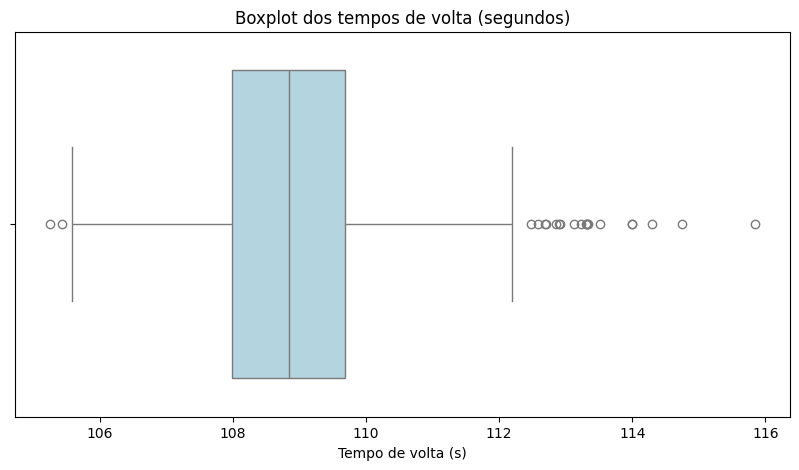

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


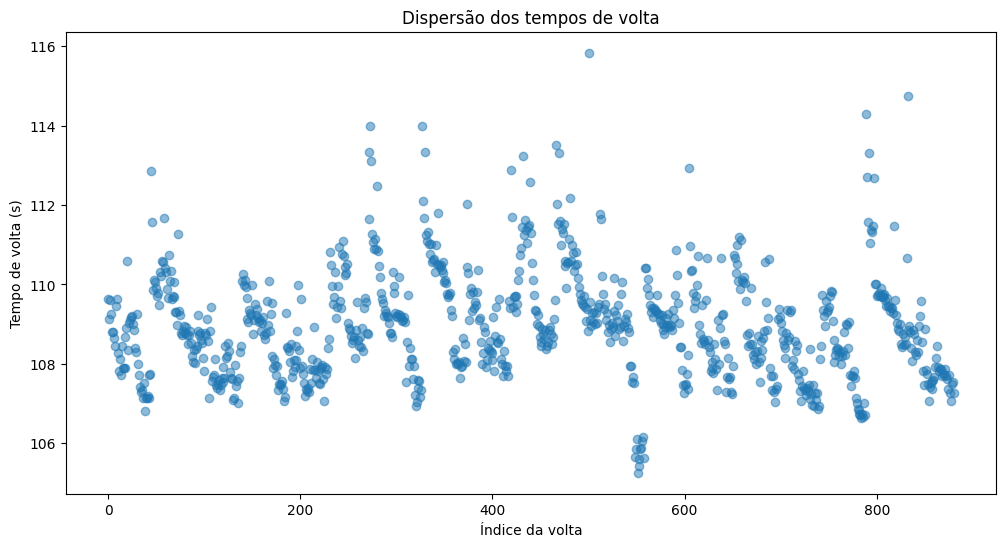

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


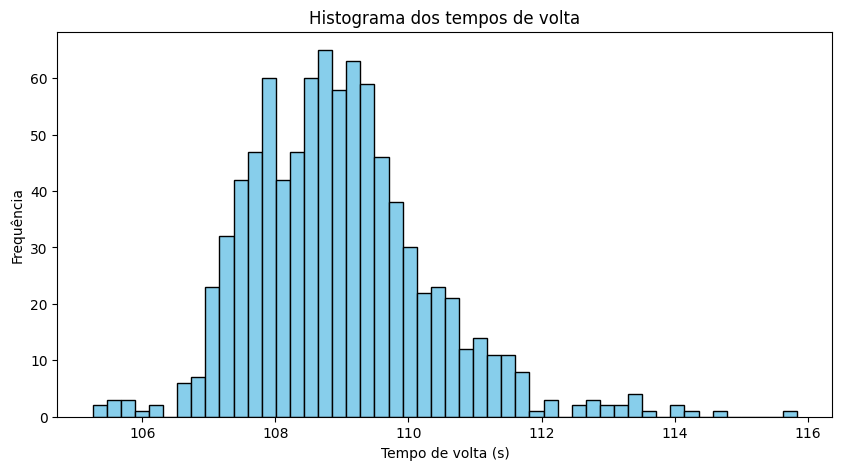

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


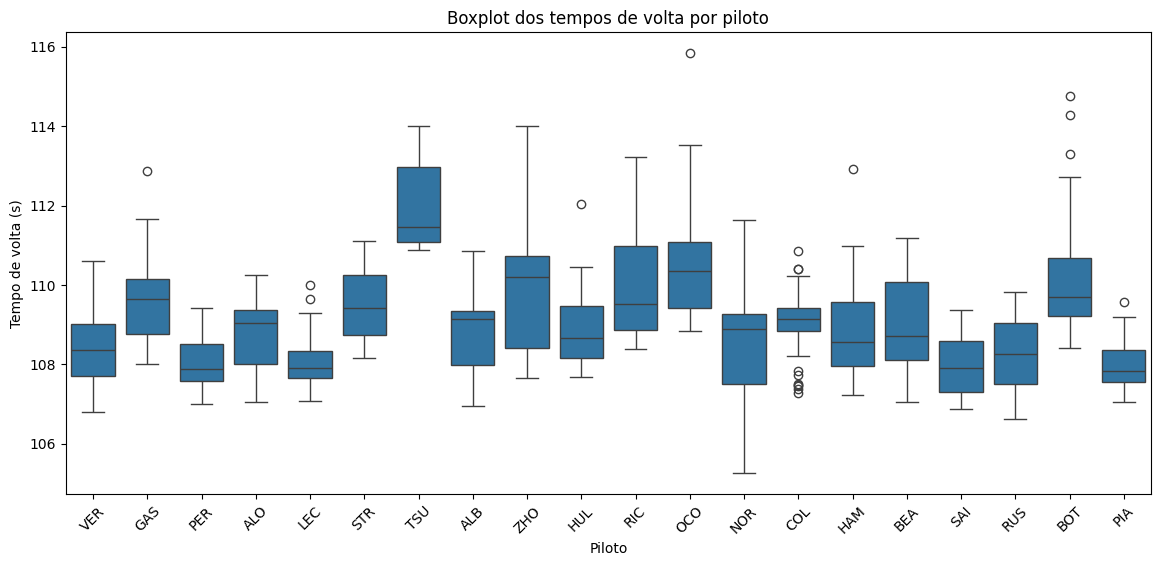

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
NOR   0 days 00:01:45.255000
RUS   0 days 00:01:46.628000
VER   0 days 00:01:46.798000
SAI   0 days 00:01:46.866000
ALB   0 days 00:01:46.947000
PER   0 days 00:01:47.013000
BEA   0 days 00:01:47.048000
ALO   0 days 00:01:47.057000
PIA   0 days 00:01:47.060000
LEC   0 days 00:01:47.067000
HAM   0 days 00:01:47.236000
COL   0 days 00:01:47.274000
ZHO   0 days 00:01:47.644000
HUL   0 days 00:01:47.691000
GAS   0 days 00:01:48.018000
STR   0 days 00:01:48.148000
RIC   0 days 00:01:48.380000
BOT   0 days 00:01:48.418000
OCO   0 days 00:01:48.831000
TSU   0 days 00:01:50.887000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Azerbaijao'
race_date = '2024-09-15'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,46,108.830652,1.004046,106.947,110.846,109.1470,3.899,2024,Azerbaijao,2024-09-15
1,ALO,46,108.817304,0.903184,107.057,110.262,109.0515,3.205,2024,Azerbaijao,2024-09-15
2,BEA,46,109.011804,1.198676,107.048,111.194,108.7085,4.146,2024,Azerbaijao,2024-09-15
3,BOT,45,110.094400,1.513604,108.418,114.753,109.6870,6.335,2024,Azerbaijao,2024-09-15
4,COL,46,109.041826,0.833122,107.274,110.858,109.1545,3.584,2024,Azerbaijao,2024-09-15
5,GAS,48,109.589562,1.017586,108.018,112.861,109.6430,4.843,2024,Azerbaijao,2024-09-15
6,HAM,46,108.854435,1.186546,107.236,112.922,108.5695,5.686,2024,Azerbaijao,2024-09-15
7,HUL,46,108.893130,0.905871,107.691,112.034,108.6635,4.343,2024,Azerbaijao,2024-09-15
8,LEC,46,108.023870,0.604123,107.067,109.990,107.9005,2.923,2024,Azerbaijao,2024-09-15
9,NOR,46,108.270391,1.586083,105.255,111.638,108.8990,6.383,2024,Azerbaijao,2024-09-15


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,46,108.830652,1.004046,106.947,110.846,109.1470,3.899,2024,Azerbaijao,2024-09-15,51.0,True
1,ALO,46,108.817304,0.903184,107.057,110.262,109.0515,3.205,2024,Azerbaijao,2024-09-15,51.0,True
2,BEA,46,109.011804,1.198676,107.048,111.194,108.7085,4.146,2024,Azerbaijao,2024-09-15,51.0,True
3,BOT,45,110.094400,1.513604,108.418,114.753,109.6870,6.335,2024,Azerbaijao,2024-09-15,50.0,True
4,COL,46,109.041826,0.833122,107.274,110.858,109.1545,3.584,2024,Azerbaijao,2024-09-15,51.0,True
5,GAS,48,109.589562,1.017586,108.018,112.861,109.6430,4.843,2024,Azerbaijao,2024-09-15,51.0,True
6,HAM,46,108.854435,1.186546,107.236,112.922,108.5695,5.686,2024,Azerbaijao,2024-09-15,51.0,True
7,HUL,46,108.893130,0.905871,107.691,112.034,108.6635,4.343,2024,Azerbaijao,2024-09-15,51.0,True
8,LEC,46,108.023870,0.604123,107.067,109.990,107.9005,2.923,2024,Azerbaijao,2024-09-15,51.0,True
9,NOR,46,108.270391,1.586083,105.255,111.638,108.8990,6.383,2024,Azerbaijao,2024-09-15,51.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,32.0,25.5,0.000000,0.392157,0.607843
1,ALO,1,12.0,25.5,0.000000,0.215686,0.784314
2,BEA,1,15.0,25.5,0.000000,0.274510,0.725490
3,BOT,1,12.0,25.0,0.000000,0.220000,0.780000
4,COL,1,11.0,25.5,0.000000,0.196078,0.803922
5,GAS,1,51.0,25.5,0.019608,0.000000,0.980392
6,HAM,1,13.0,25.5,0.000000,0.235294,0.764706
7,HUL,1,16.0,25.5,0.000000,0.294118,0.705882
8,LEC,1,17.0,25.5,0.000000,0.313725,0.686275
9,NOR,1,38.0,25.5,0.000000,0.274510,0.725490


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,46,108.830652,1.004046,106.947,110.846,109.1470,3.899,2024,Azerbaijao,2024-09-15,51.0,True,1,32.0,25.5,0.000000,0.392157,0.607843
1,ALO,46,108.817304,0.903184,107.057,110.262,109.0515,3.205,2024,Azerbaijao,2024-09-15,51.0,True,1,12.0,25.5,0.000000,0.215686,0.784314
2,BEA,46,109.011804,1.198676,107.048,111.194,108.7085,4.146,2024,Azerbaijao,2024-09-15,51.0,True,1,15.0,25.5,0.000000,0.274510,0.725490
3,BOT,45,110.094400,1.513604,108.418,114.753,109.6870,6.335,2024,Azerbaijao,2024-09-15,50.0,True,1,12.0,25.0,0.000000,0.220000,0.780000
4,COL,46,109.041826,0.833122,107.274,110.858,109.1545,3.584,2024,Azerbaijao,2024-09-15,51.0,True,1,11.0,25.5,0.000000,0.196078,0.803922
5,GAS,48,109.589562,1.017586,108.018,112.861,109.6430,4.843,2024,Azerbaijao,2024-09-15,51.0,True,1,51.0,25.5,0.019608,0.000000,0.980392
6,HAM,46,108.854435,1.186546,107.236,112.922,108.5695,5.686,2024,Azerbaijao,2024-09-15,51.0,True,1,13.0,25.5,0.000000,0.235294,0.764706
7,HUL,46,108.893130,0.905871,107.691,112.034,108.6635,4.343,2024,Azerbaijao,2024-09-15,51.0,True,1,16.0,25.5,0.000000,0.294118,0.705882
8,LEC,46,108.023870,0.604123,107.067,109.990,107.9005,2.923,2024,Azerbaijao,2024-09-15,51.0,True,1,17.0,25.5,0.000000,0.313725,0.686275
9,NOR,46,108.270391,1.586083,105.255,111.638,108.8990,6.383,2024,Azerbaijao,2024-09-15,51.0,True,1,38.0,25.5,0.000000,0.274510,0.725490


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [23]:
df_completo.to_csv('df_completoAzerbaijao.csv', index=False)
